In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
save_base = '/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/plots_presentations_etc/pure_rebound_bp_2-6-24'

In [3]:
# this deletes any unneeded columns from the rebound dataframe before saving again. 
rdf_path = '/home/kdriessen/gh_master/acr/pub/data/reb_df.csv'
reb_df = pd.read_csv(rdf_path)
for col in reb_df.columns:
    if "Unnamed" in col:
        del reb_df[col]
reb_df = reb_df.loc[reb_df.state == 'NREM']

/tmp/ipykernel_1414591/1485064609.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  reb_df = pd.read_csv(rdf_path)


In [6]:
def get_diff_df(reb_df, sub, exp, band='delta'):
    chans = reb_df.loc[reb_df.exp==exp].sbj(sub).channel.unique()
    avg = reb_df.loc[reb_df.Band==band].loc[reb_df.exp==exp].sbj(sub).groupby(['store', 'channel']).Bandpower.median()
    avgs = avg.to_frame().reset_index()
    diffs = avgs.prb('NNXo').Bandpower.values / avgs.prb('NNXr').Bandpower.values
    diff_df = pd.DataFrame({'channel': chans, 'diff': diffs, "exp":exp, "sub":sub, "band":band})
    return diff_df

def full_subject_diffs(reb_df, sub, band='delta'):
    from acr.utils import swi_subs_exps
    exps = swi_subs_exps[sub]
    dfs = {}
    for exp in exps:
        dfs[exp] = get_diff_df(reb_df, sub, exp, band=band)
    return pd.concat(dfs.values())

def full_subject_all_bands(reb_df, sub):
    bands = list(kde.utils.spectral.bands.keys())
    dfs = {}
    for band in bands:
        dfs[band] = full_subject_diffs(reb_df, sub, band=band)
    return pd.concat(dfs.values())

In [7]:
for subject in ['ACR_19']:
    ab = full_subject_all_bands(reb_df, subject)
    ab.reset_index(drop=True, inplace=True)
    ab.channel = ab.channel.astype(str)
    fig = px.bar(ab, x='diff', y='channel', color='exp', facet_col='band', barmode='group', facet_col_spacing=0.02, width=2200, height=1800, color_discrete_sequence=['royalblue', 'crimson', 'green'], template='ggplot2', title=f'{subject} Bandpower | MEDIAN NNXo-NNXr | Rebound = 1hr NREM')
    fig.update_xaxes(matches=None)
    fig.update_yaxes(autorange='reversed')
    fig.update_layout(
        font_color="black",
        font_size=20,
        title_font_size=28,
    )
    fig.show()
    #fig.write_image(f'{save_base}/{subject}--MEDIAN_bp_diffs.png', scale=3, engine="kaleido")

# Combining Subjects

In [8]:
new_reb_df = {}
for subject in swi_subs_exps:
    for exp in swi_subs_exps[subject]:
        new_reb_df[f'{subject}_{exp}'] = reb_df.sbj(subject).loc[reb_df.exp==exp]

In [9]:
rdf = pd.concat(new_reb_df.values())

In [10]:
ctrl = rdf.loc[rdf.exp_type=='control'].loc[rdf.Band=='delta']
gtacr = rdf.loc[rdf.exp_type=='exp'].loc[rdf.Band=='delta']
#gtacr = gtacr.loc[gtacr.subject != 'ACR_14']
som = rdf.loc[rdf.exp_type=='som'].loc[rdf.Band=='delta']

Text(0.5, 0.98, 'Control Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

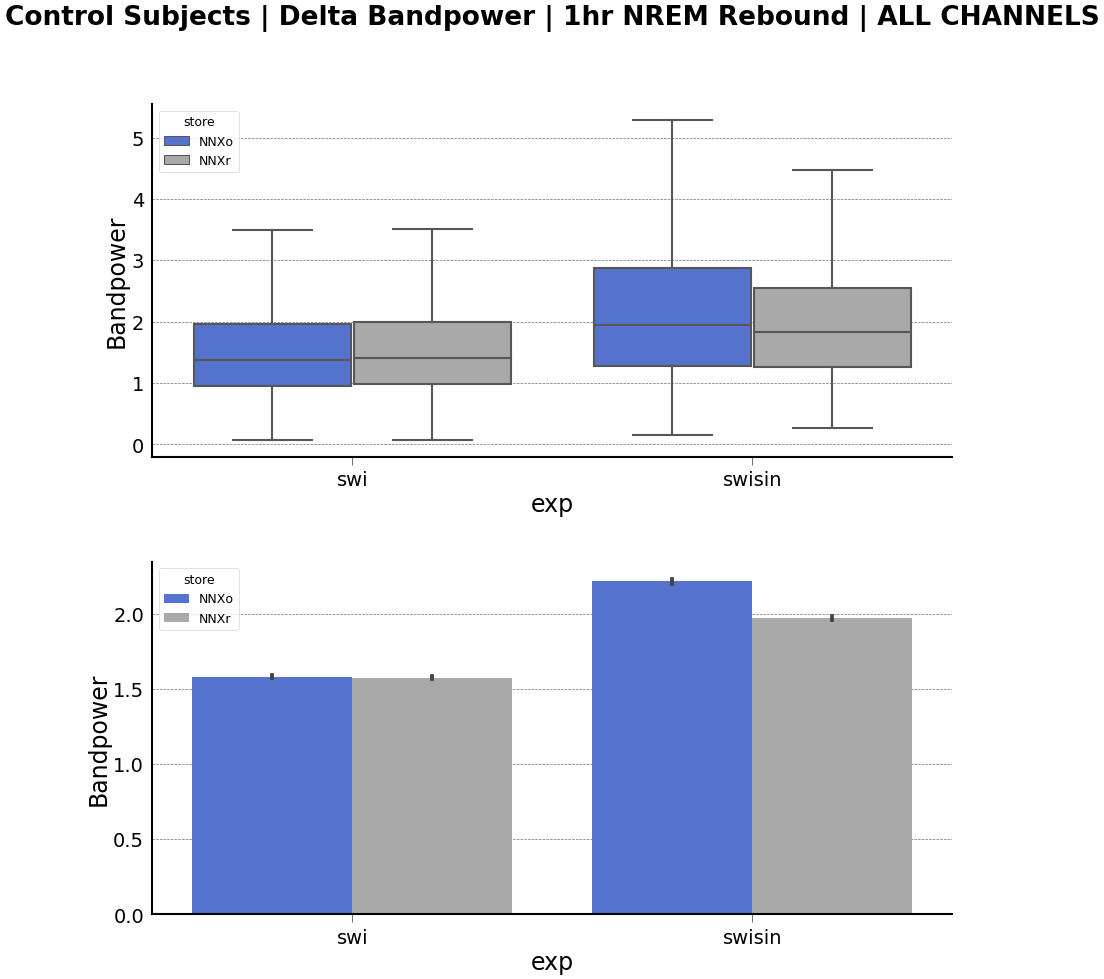

In [11]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=ctrl.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=ctrl.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('Control Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

Text(0.5, 0.98, 'ACR Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

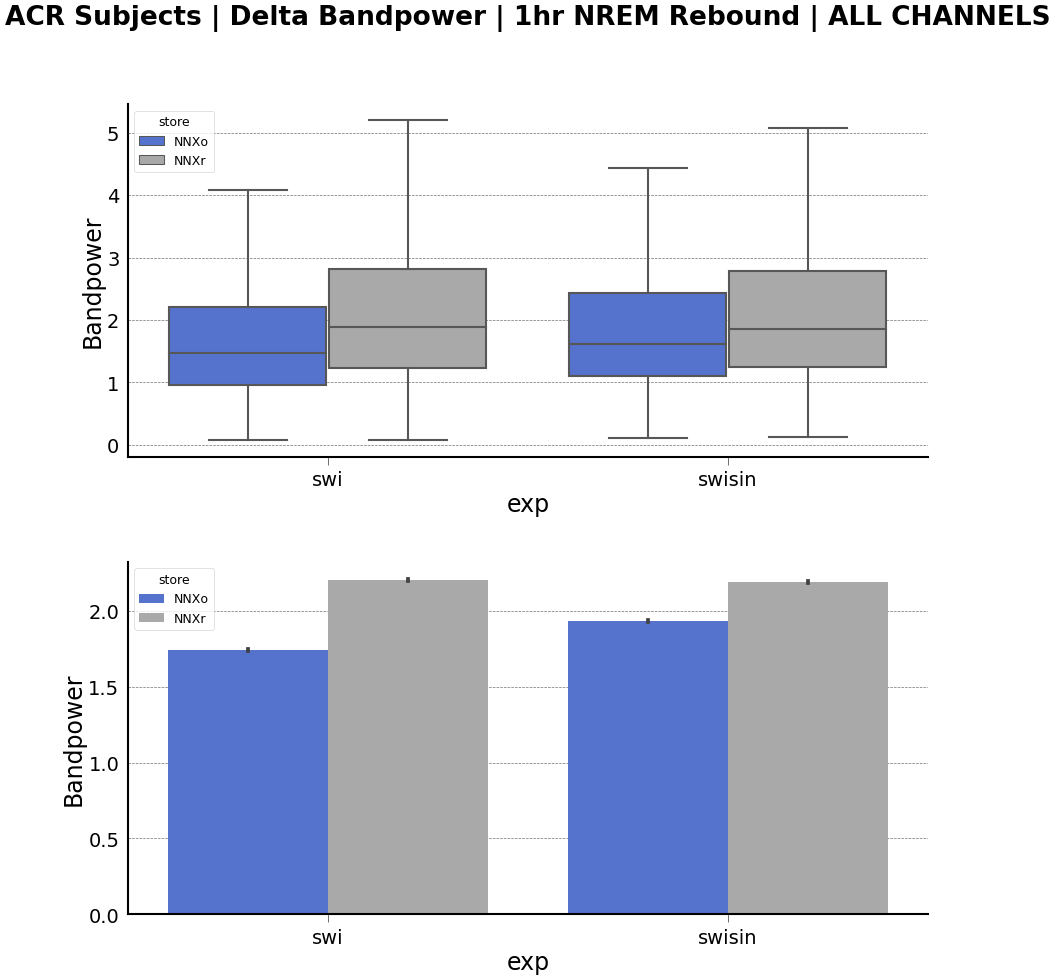

In [12]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=gtacr.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=gtacr.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

Text(0.5, 0.98, 'SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

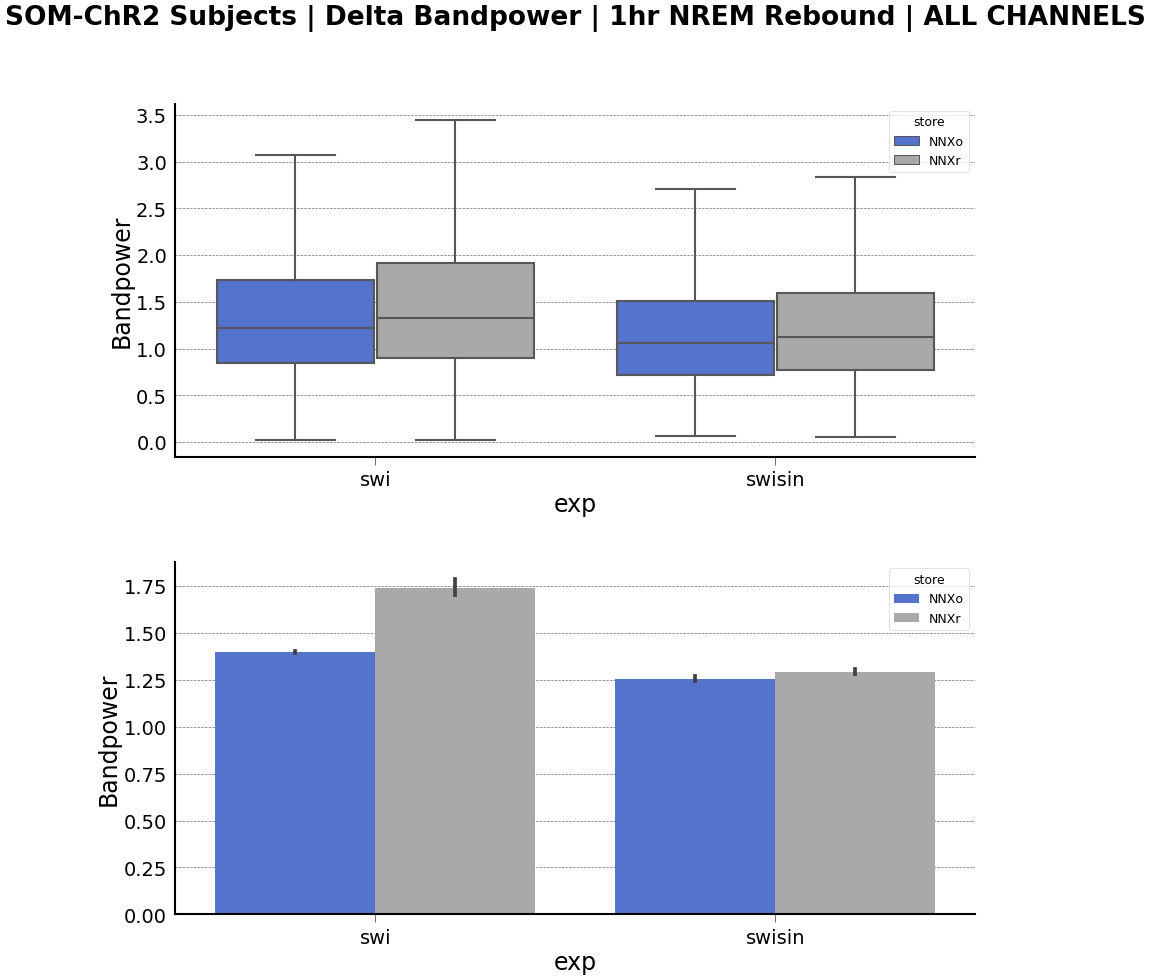

In [13]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=som.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=som.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

# Histology based

In [ ]:
# convert all layers to strings
rdf.layer = rdf.layer.astype(str)

In [ ]:
rdf['pure_chan'] = 'N/A'
rdf['histo_based'] = 'N/A'

In [ ]:
rdf.loc[rdf['channel'] <= 8, 'pure_chan'] = 'lower'
rdf.loc[rdf['channel'] >= 9, 'pure_chan'] = 'upper'

In [ ]:
rdf.loc[rdf.layer.isin(['0', '1', '2/3']), 'histo_based'] = 'superficial'
#rdf.loc[rdf.layer.isin(['4']), 'histo_based'] = 'middle'
rdf.loc[rdf.layer.isin(['5', '6a']), 'histo_based'] = 'deep'

In [ ]:
ctrl = rdf.loc[rdf.exp_type=='control'].loc[rdf.Band=='delta']
gtacr = rdf.loc[rdf.exp_type=='exp'].loc[rdf.Band=='delta']
#gtacr = gtacr.loc[gtacr.subject != 'ACR_14']
som = rdf.loc[rdf.exp_type=='som'].loc[rdf.Band=='delta']

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=gtacr.loc[gtacr.pure_chan=='lower'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Lower Channels (1-8)')
sns.barplot(data=gtacr.loc[gtacr.pure_chan=='upper'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Upper Channels (9-16)')

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=gtacr.loc[gtacr.histo_based=='superficial'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Superficial Layers (0, 1, 2/3)')
sns.barplot(data=gtacr.loc[gtacr.histo_based=='deep'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Deep Layers (5, 6a)')

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=som.loc[som.pure_chan=='lower'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Lower Channels (1-8)')
sns.barplot(data=som.loc[som.pure_chan=='upper'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Upper Channels (9-16)')

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=som.loc[som.histo_based=='superficial'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Superficial Layers (0, 1, 2/3)')
sns.barplot(data=som.loc[som.histo_based=='deep'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Deep Layers (5, 6a)')

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

In [ ]:
new_rdf = rdf.loc[rdf.Band=='delta'].groupby(['subject', 'exp', 'layer', 'store']).Bandpower.median().to_frame().reset_index()
new_rdf['diff'] = new_rdf.groupby(['subject', 'exp', 'layer'])['Bandpower'].diff().fillna(0)

In [ ]:
histo_diffs = new_rdf.loc[new_rdf['diff'] != 0]
# invert the diff column
histo_diffs['diff'] = histo_diffs['diff'] * -1

In [ ]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['1'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

In [ ]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['2/3'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

In [ ]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['4'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

In [ ]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['5'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

In [ ]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['6a'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

# SWI ONLY

In [ ]:
swa = rdf.loc[rdf.Band=='delta']

In [ ]:
control_means = swa.prb('NNXr').groupby(['subject', 'exp', 'channel']).Bandpower.mean().to_frame().reset_index()

In [ ]:
control_means.sbj('ACR_14').chnl(1).loc[control_means.exp=='swi']['Bandpower'].values[0]

In [ ]:
swa_op = swa.prb('NNXo')

In [ ]:
op_rel = swa_op.sbj('ACR_14').loc[swa_op.exp=='swi'].loc[swa_op.channel==1]['Bandpower'].values / control_means.sbj('ACR_14').chnl(1).loc[control_means.exp=='swi']['Bandpower'].values[0]

In [ ]:
swa_op.sbj('ACR_14').loc[swa_op.exp=='swi'].loc[swa_op.channel==1, 'Bandpower'] = op_rel 

In [ ]:
swa_op.groupby(['subject', 'exp', 'channel'])['Bandpower']/control_means['Bandpower'].values

In [ ]:
swa_14 = swa.loc[swa.subject=='ACR_14']